In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from pathlib import Path
import MDAnalysis as mda

In [2]:
structure_path = Path("../../dynophores/tests/data/in/startframe.pdb")

In [3]:
smiles = "c1cc2c(cc1c3cnco3)C(=CNc4ccc5c(c4)CS(=O)(=O)C5)C(=O)N2"

## Save ligand as PDB

In [4]:
universe = mda.Universe(structure_path)
ligand = universe.select_atoms("resname LS3")
ligand.write("ligand.pdb")

/home/dominique/.local/miniforge3/envs/dynophores/lib/python3.9/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
/home/dominique/.local/miniforge3/envs/dynophores/lib/python3.9/site-packages/MDAnalysis/core/selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np

In [5]:
pdb_atom_ids = [atom.id for atom in ligand.atoms]

## Load ligand in `rdkit`

### 1. Load PDB ligand

43


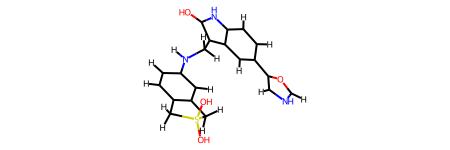

In [6]:
molecule = Chem.MolFromPDBFile("ligand.pdb", removeHs=False)
print(molecule.GetNumAtoms())
molecule

### 2. Set PDB atom serial numbers to `rdkit` molecule

In [7]:
if len(pdb_atom_ids) == molecule.GetNumAtoms():
    for atom, pdb_atom_id in zip(molecule.GetAtoms(), pdb_atom_ids):
        atom.SetIntProp("pdb_atom_id", int(pdb_atom_id))
else:
    raise ValueError(f"Number of atoms in RDKit and MDAnalysis are not the same.")

### 3. Remove hydrogens

28


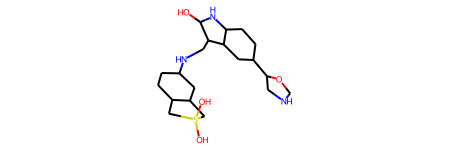

In [8]:
molecule = Chem.RemoveHs(molecule)
print(molecule.GetNumAtoms())
molecule

### 4. Assign bond orders based on SMILES

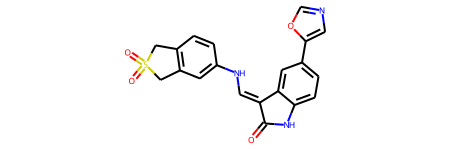

In [9]:
reference_molecule = Chem.MolFromSmiles(smiles)
molecule = AllChem.AssignBondOrdersFromTemplate(reference_molecule, molecule)
AllChem.Compute2DCoords(molecule)
molecule

## Highlight superfeatures

In [10]:
# PDB serial numbers: 2255-2282
superfeatures = [
    "HBA[4618]",
    "AR[4605,4607,4603,4606,4604]",
    "HBD[4598]",
    "HBA[4606]",
    "AR[4622,4615,4623,4613,4614,4621]",
    "HBD[4612]",
    "HBA[4619]",
    "HBA[4596]",
    "H[4615,4623,4622,4613,4621,4614]",
    "H[4599,4602,4601,4608,4609,4600]",
]
superfeatures = {
    superfeature: [int(i) for i in superfeature.split("[")[1][:-1].split(",")]
    for superfeature in superfeatures
}
superfeatures

{'HBA[4618]': [4618],
 'AR[4605,4607,4603,4606,4604]': [4605, 4607, 4603, 4606, 4604],
 'HBD[4598]': [4598],
 'HBA[4606]': [4606],
 'AR[4622,4615,4623,4613,4614,4621]': [4622, 4615, 4623, 4613, 4614, 4621],
 'HBD[4612]': [4612],
 'HBA[4619]': [4619],
 'HBA[4596]': [4596],
 'H[4615,4623,4622,4613,4621,4614]': [4615, 4623, 4622, 4613, 4621, 4614],
 'H[4599,4602,4601,4608,4609,4600]': [4599, 4602, 4601, 4608, 4609, 4600]}

In [11]:
mol = molecule

In [12]:
from collections import defaultdict
import matplotlib

In [13]:
from dynophores.definitions import FEATURE_COLORS

FEATURE_COLORS

{'HBA': 'firebrick',
 'HBD': 'green',
 'H': 'gold',
 'AR': 'mediumblue',
 'PI': 'blue',
 'NI': 'red'}

In [14]:
colors = {}
for name, color in FEATURE_COLORS.items():
    colors[name] = matplotlib.colors.to_rgb(color)
colors

{'HBA': (0.6980392156862745, 0.13333333333333333, 0.13333333333333333),
 'HBD': (0.0, 0.5019607843137255, 0.0),
 'H': (1.0, 0.8431372549019608, 0.0),
 'AR': (0.0, 0.0, 0.803921568627451),
 'PI': (0.0, 0.0, 1.0),
 'NI': (1.0, 0.0, 0.0)}

In [15]:
highlight_atoms = defaultdict(list)
highlight_bonds = defaultdict(list)
highlight_radius = {}
highligh_linewidth = {}
rings = []

mol_rings = mol.GetRingInfo().AtomRings()

for superfeature_id, pdb_atom_ids in superfeatures.items():

    # Map PDB atom IDs to RDKit atom IDs
    rdkit_atom_idx = [
        atom.GetIdx() for atom in mol.GetAtoms() if atom.GetIntProp("pdb_atom_id") in pdb_atom_ids
    ]
    # Get subpocket color
    feature_name = superfeature_id.split("[")[0]
    color = colors[feature_name]

    # Highlight information for rings
    for ring in mol_rings:
        # Add only those rings that belong to current fragment
        if len(set(ring) - set(rdkit_atom_idx)) == 0:
            rings.append((ring, color))

    for atom_idx in rdkit_atom_idx:

        # Highlight information for atoms
        highlight_atoms[atom_idx].append(color)
        highlight_radius[atom_idx] = 0.4

        # Highlight information for bonds
        atom = mol.GetAtomWithIdx(atom_idx)
        bonds = atom.GetBonds()
        for bond in bonds:
            atom_idx_begin = bond.GetBeginAtom().GetIdx()
            atom_idx_end = bond.GetEndAtom().GetIdx()
            if (atom_idx_begin in rdkit_atom_idx) and (atom_idx_end in rdkit_atom_idx):
                bond_idx = bond.GetIdx()
                highlight_bonds[bond_idx].append(color)
                highligh_linewidth[bond_idx] = 2

In [16]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Chem, Geometry
from IPython.display import Image

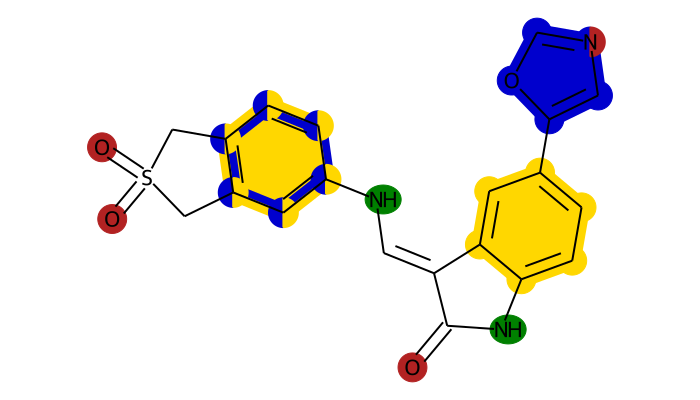

In [17]:
legend = ""
width = 700
height = 400
d2d = rdMolDraw2D.MolDraw2DCairo(width, height)
dos = d2d.drawOptions()
dos.useBWAtomPalette()

# First draw circles to highlight full rings
d2d.DrawMoleculeWithHighlights(
    mol, legend, dict(highlight_atoms), dict(highlight_bonds), highlight_radius, highligh_linewidth
)
d2d.ClearDrawing()
conf = mol.GetConformer()
for (ring, color) in rings:
    positions = []
    for atom_idx in ring:
        position = Geometry.Point2D(conf.GetAtomPosition(atom_idx))
        positions.append(position)
    d2d.SetFillPolys(True)
    d2d.SetColour(color)
    d2d.DrawPolygon(positions)
dos.clearBackground = False

# Now draw on top (again) the molecule with highlighted atoms and bonds
d2d.DrawMoleculeWithHighlights(
    mol, legend, dict(highlight_atoms), dict(highlight_bonds), highlight_radius, highligh_linewidth
)
d2d.FinishDrawing()

# Show PNG text as image
Image(d2d.GetDrawingText())